In [36]:
display("text/javascript", """MathJax.Hub.Config({TeX: { equationNumbers: { autoNumber: "AMS" } }});""")

In [37]:
using LightGraphs, GraphPlot, SimpleWeightedGraphs

In [38]:
using Plots
plotlyjs()

Plots.PlotlyJSBackend()

# Consensus Protocols in Decentralized Systems

## A Motivating Example: Distributed Linear Least Squares
Consider $n$ agents, denoted by their index in the set $\{1, \ldots, n\}$. Suppose that they collectively want to estimate a parameter $\theta \in \mathbb R^m$ in their environment. Each node makes a linear measurement of the parameter, of the form
$$
y_i = C_i \theta + v_i
$$
with $C_i$ a matrix associated to agent $i$ and $v_i$ some zero-mean Gaussian noise with (positive-definite) covariance matrix $\Sigma_i$. All the noise vectors $v_i$ are independent. We assume that the matrix $C = [C_1;\ldots;C_m]$ (Matlab notation) formed by vertically stacking the $C_i$ matrices is full column rank (this requires enough non-redundant measurements). The estimator of $\hat \theta$ of $\theta$ that minimizes the mean-squared error for this Gaussian measurement case (and also the maximum likelihood estimator) is the following weighted least-squares estimate
\begin{equation} \label{eq: WLLS problem}
\hat \theta \in \arg \min_\theta \; f(\theta) := \frac{1}{2} \sum_{i=1}^n (y_i - C_i \theta)^T \Sigma_i^{-1} (y_i - C_i \theta)
\end{equation}
The weighting by $\Sigma_i^{-1}$ gives less importance to measurements that are noisier. The solution to this quadratic optimization problem can be expressed analytically as
$$
\hat \theta = \left( \frac{1}{n} \sum_{i=1}^n C_i^T \Sigma_i^{-1} C_i \right)^{-1} \left( \frac{1}{n} \sum_{i=1}^n C_i^T \Sigma_i^{-1} y_i\right),
$$
i.e., as the ratio of two quantities averaged over the sensing nodes. One way for each node in a network to compute $\theta$ is for the nodes to computed these two averages. The non-trivial constraint is that this must be done in a distributed manner, i.e., with each node communicating only with its neighbors. Note that node $i$ knows $C_i$, $\Sigma_i$ and $y_i$.

### A distributed optimization point-of-view
The problem $\eqref{eq: WLLS problem}$ can also be viewed as an example of an optimization problem to be solved in a distributed way. There are various flavors of such problems, and many distributed optimization methods have been developed. In some cases for example, the vector to optimize can be partitioned into groups of variables, one group per agent, and distributed optimization algorithms can be designed using so-called primal-dual methods in optimization. In the problem above however, there is a common variable $\theta$ shared between the nodes, that they should agree on. In a centralized system, we could consider running a simple (but inefficient) steepest descent procedure to find the optimum $\theta$ asymptotically, via the iterations
$$
\theta_{k+1} = \theta_k - \alpha_k \partial f(\theta_k) / \partial \theta,
$$
starting from some initial estimate, e.g., $\theta_0 = 0$, with $\alpha_k$ some stepsizes that must satisfy certain conditions to achieve convergence. Note that here the gradient of $f$ can be written
$$
\partial f / \partial \theta = \sum_{i=1}^n C_i^T \Sigma_i^{-1} C_i \theta - C_i^T \Sigma_i^{-1} y_i.
$$
So the agents could start from some common value $\theta_0$. Then, by inducation, suppose they agree at period $k$ on the current iterate $\theta_k$ and on the stepsize $\alpha_k$. They could compute the gradient above by some distributed algorithm to compute the sum (or the average again, which is just the gradient scaled by $1/n$ and hence still a gradient direction). Finally after some rounds of this gradient computation scheme they could implement the gradient descent step synchronously to obtain $\theta_{k+1}$.

Yet another approach to design a distributed algorithm for this problem is to consider it as an instance of a constrained optimization problem of the type
\begin{align*}
\min_{\theta_1, \ldots, \theta_n} & \sum_{i=1}^n f_i (\theta_i) \\
\text{s.t. } & \theta_1 = \theta_2 = \ldots = \theta_n.
\end{align*}
Using this trick of adding variables $\theta_i$, the objective completely decouples so that each agent can run a an optimization routine locally (e.g., of a gradient descent type). Then after each agent converges, they run a consensus (averaging) scheme to enfore the equality constraints, and repeat the procedure. With some effort, one can make such a scheme work, with theoretical guarantees as well.

We will cover in this class some examples of such distributed optimization algorithms more formally.

In the end, we emphasize the following points:
- There are a priori many ways of designing distributed schemes to solve a give problems, such as computing an optimum solution of $\eqref{eq: WLLS problem}$ (in fact, there are many known ways of computing such an optimum solution even in the centralized case). Different methods can achieve different trade-offs, in terms of implementation algorithmic simplicity, efficiency, convergence speed and performance, etc.
- The problem of computing an average of quantities held at different nodes in a network, and to do so in a simple, decentralized way, arises in a surprisingly large number of problems. But even for this basic task, many variations exist, and many scenarios can be considered, e.g., on the topology of the network, the presence of directional links, the quality of the communication over these links, etc. 

We start our discussion with examples of distributed consensus algorithms, in the simplest setting mostly: undirected, time-invariant connectivity graphs. In the discussion, we do not attempt to provide the most general results, but instead to illustrate the basic ideas in a relatively simple setting.

## Linear Iterations Achieving Consensus and Average Consensus

We are interested in understanding the asymptotic behavior of the following iterations
$$
x_{k+1} = W x_k,
$$
starting from some initial condition $x_0 \in \mathbb R^n$, for some matrix $n \times n$ matrix $W$ with nonnegative coefficients. The matrix $W$ can be naturally associated to a digraph $G_W$, for which it represents the weight matrix. Concretely, the situation models a network of $n$ nodes as explained above. Node $i$ initially knows its initial value $x_{0,i}$. At each period $k \geq 0$, it has in memory its current value $x_{k,i}$ and simply computes a linear combination of this value and that of its neighbors
$$
x_{i,k+1} = w_{ii} x_{i,k} + \sum_{j \in N(i)} w_{ij} x_{j,k}.
$$
Note in particular that in this case the directed graph $G$ will typically have self-loops, with weights $w_{ii}$, since it is natural for a node to keep a memory of its previous value when forming the linear combination. Two basic questions arise:
- When do we have convergence to a consensus, i.e., $x_k \to w \mathbf{1}_n$ as $k \to \infty$, with $w \in \mathbb R$? Consensus means all nodes asymptotically agree on a common value $w$.
- When does this value equal the average of initial values, i.e., $w = \frac{1}{n} x_0^T \mathbf{1}_n = \frac{1}{n}\sum_{i=1}^n x_{i,0}$?

**Example** (successive averaging): A basic example of such an iterative scheme is obtained by having each node in an undirected graph average its own value and that of its neighbors, with equal weights. For example

In [39]:
network = Graph(4)
add_edge!(network, 1, 2)
add_edge!(network, 2, 3)
add_edge!(network, 3, 4)
add_edge!(network, 2, 4)
A = adjacency_matrix(network)
# Averaging matrix with equal weights for this undirected graph
W = inv((eye(A)+diagm(A*ones(size(A,1))))) * (A+eye(A))  

4×4 Array{Float64,2}:
 0.5   0.5       0.0       0.0     
 0.25  0.25      0.25      0.25    
 0.0   0.333333  0.333333  0.333333
 0.0   0.333333  0.333333  0.333333

In [40]:
nSteps = 100
xTraj = zeros(4,nSteps)
xTraj[:,1] = [1; 3; 2; 2]
for k=1:nSteps-1
    xTraj[:,k+1] = W * xTraj[:,k]
end

In [41]:
println(xTraj[:,nSteps])
println(mean(xTraj[:,1]))
plot(xTraj'[1:15,:])

[2.16667, 2.16667, 2.16667, 2.16667]
2.0


So the agents achieve consensus, but not to the average value. To predict the asymptotic consensus value, we can compute the dominant left eigenvector of $W$ (associated to the eigenvalue $1$)

In [42]:
eigvals(W')

4-element Array{Float64,1}:
 -0.147667
  0.564333
  1.0     
  0.0     

In [43]:
F = eigfact(W')
println(F[:values][3])
w = F[:vectors][:,3]
w = w/sum(w)  # need the unit-norm version of the left dominant eigenvector

0.9999999999999993


4-element Array{Float64,1}:
 0.166667
 0.333333
 0.25    
 0.25    

In [44]:
w'*xTraj[:,1]  # convergence toward this value

2.166666666666667

**Example** (Metropolis-Hastings weights): As before, we start with an undirected unweighted graph $G = (V,E)$. However, we now set the weights $w_{ij} = 1/(1+\max(d_i,d_j))$ when $i \neq j$, $\{i,j\} \in E$, and we set the weights on the diagonal in order to obtain a stochastic matrix, i.e., $w_{ii} = 1-\sum_{\{i,h\} \in E} w_{ih}$. The other weights are $0$. It is not hard to show that in this case, the weight matrix of the digraph is doubly stochastic. Moreover, we have a self-loop at each node in the digraph. The digraph is strongly connected and aperiodic, so the weight matrix is primitive. The iterations achieve consensus on the average in this case.

In [45]:
function metropolisHastingsWeights(A)  # A is the adjacency matrix of an undirected graph, so symmetric
    n = size(A,1)
    d = A*ones(n)  # degree vector 
    Wm = zeros(Float64,size(A))
    for i = 1:n, j = 1:n
        Wm[i,j] = A[i,j]/(1+max(d[i],d[j]))
    end
    for i=1:n
       Wm[i,i] = 1-(Wm[i,:]'*ones(n)-Wm[i,i])
    end
    return Wm
end

metropolisHastingsWeights(g::LightGraphs.SimpleGraphs.SimpleGraph) = metropolisHastingsWeights(adjacency_matrix(g))

#Wm = metropolisHastingsWeights(A)
Wm = metropolisHastingsWeights(network)

4×4 Array{Float64,2}:
 0.75  0.25  0.0       0.0     
 0.25  0.25  0.25      0.25    
 0.0   0.25  0.416667  0.333333
 0.0   0.25  0.333333  0.416667

In [46]:
xTraj_bis = zeros(4,nSteps)
xTraj_bis[:,1] = [1; 3; 2; 2]
for k=1:nSteps-1
    xTraj_bis[:,k+1] = Wm * xTraj_bis[:,k]
end

Let us see that we now achieve consensus on the average.

In [47]:
println(xTraj_bis[:,nSteps])
println(mean(xTraj_bis[:,1]))
plot(xTraj_bis'[1:15,:])

[2.0, 2.0, 2.0, 2.0]
2.0


Note however that the convergence is now slower. In general, the problem of designing the best weights to achieve average consensus as fast as possible is of interest. Some techniques for this exist, based on semi-definite programming.

## Laplacian Flow

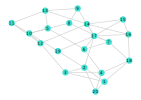

In [48]:
# Create a random undirected graph with 20 nodes, each with 3 neighbors
srand(12345);
n = 20;
g1 = watts_strogatz(n, 5, 0.5)
gplot(g1,nodelabel=1:nv(g1))

In [49]:
L = laplacian_matrix(g1);
Matrix(L)

20×20 Array{Int64,2}:
  4  -1  -1   0   0   0   0   0   0  …   0   0   0   0   0   0  -1   0  -1
 -1   5  -1   0   0   0   0   0   0      0   0   0   0   0  -1   0  -1  -1
 -1  -1   4  -1   0   0   0   0   0     -1   0   0   0   0   0   0   0   0
  0   0  -1   4   0  -1   0   0   0      0   0   0   0   0   0  -1   0  -1
  0   0   0   0   3  -1   0   0   0      0  -1   0   0   0   0   0   0   0
  0   0   0  -1  -1   4  -1   0   0  …   0   0   0   0   0  -1   0   0   0
  0   0   0   0   0  -1   4  -1   0      0   0   0   0   0  -1  -1   0   0
  0   0   0   0   0   0  -1   3  -1      0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0  -1   3      0  -1   0   0   0  -1   0   0   0
  0   0   0   0  -1   0   0  -1   0     -1   0   0   0   0   0   0  -1   0
  0   0   0   0   0   0   0   0   0  …  -1  -1   0   0   0   0   0   0   0
  0   0  -1   0   0   0   0   0   0      4   0  -1   0   0   0   0   0   0
  0   0   0   0  -1   0   0   0  -1      0   4  -1   0   0   0   0   0   0
  0

In [50]:
# Initial condition for each node
nsteps = 400
xTraj = zeros(n,nsteps)
xTraj[:,1] = 0.1+rand(n)
println("Desired average value: $(mean(xTraj[:,1]))")
δt = 0.01
for k=1:nsteps-1
    xTraj[:,k+1] = xTraj[:,k] - δt * L * xTraj[:,k]
end

Desired average value: 0.6057024131625834


In [51]:
#λ₂ = (sort(eigvals(Matrix(L))))[2]
λ₂ = (sort(laplacian_spectrum(g1)))[2]

0.8875441562711723

In [52]:
plot(xTraj')  # plot state trajectories for the n agents

## Distributed Optimization

In [53]:
# Problem set-up - Define each agent's cost function
nagents = 10
preferedValues = randn(nagents)
agentParameters = rand(nagents)
# quadratic functions for simplicity
individualFunction(x, prefValue, agentParam) = agentParam * (prefValue - x)^2;
individualFunctiongradient(x, prefValue, agentParam) = 2 * agentParam * (x - prefValue);
function totalObjective(x,prefValues,agentParams) 
    v = individualFunction(x, prefValues[1], agentParams[1])
    for i = 2:length(prefValues)
        v = v + individualFunction(x, prefValues[i], agentParams[i])
    end
    return v
end;

Let's first compute the optimum value of the common variable, using a centralized method. The problem is convex, so we can use a convex programming solver.

In [54]:
# Pgk.add("Convex")
# Pkg.checkout("Convex")
using Convex

In [55]:
x = Variable()
#obj = individualFunction(x, preferedValues[1], agentParameters[1])
#for i=2:nagents
#    obj = obj + individualFunction(x, preferedValues[i], agentParameters[i])
#end
obj = totalObjective(x, preferedValues, agentParameters)
problem = minimize(obj);

In [56]:
solve!(problem);

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 41
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 12, constraints m = 41
Cones:	primal zero / dual free vars: 1
	linear vars: 10
	soc vars: 30, soc blks: 10
Setup time: 4.13e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.50e-05 
   100| 8.45e-04  7.93e-03  2.05e-03  5.31e+00  5.28e+00  0.00e+00  1.08e-04 
   200| 9.74e-05  4.87e-04  6.91e-06  5.31e+00  5.31e+00  0.00e+00  1.98e-04 
   300| 9.84e-06  1.37e-04  2.

In [57]:
x.value

0.4865305949593653

### Gradient descent + average consensus (primal only method)

Now consider a decentralized algorithm. We start by defining the connectivity structure between the node.

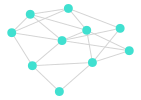

In [58]:
network1 = watts_strogatz(nagents, 4, 0.5)
gplot(network1)

In [59]:
nsteps = 5000
xTraj = zeros(nagents,nsteps);
# set the link weights for the consensus part
W_mh = metropolisHastingsWeights(network1);

In [60]:
xTraj[:,1] = preferedValues; # every agent starts with its prefered value
# stepsize for subgradient descent part - analysis shows it needs to be quite small
α_step = 1e-3 * ones(nsteps) 
#α_step = 1e-1 ./ cumsum(ones(nsteps))   
for k=1:nsteps-1
    # compute the subgradients at the current iterate 
    d = zeros(nagents)
    for i=1:nagents
       d[i] = individualFunctiongradient(xTraj[i,k], preferedValues[i], agentParameters[i])
    end
    xTraj[:,k+1] = W_mh * xTraj[:,k] - α_step[k] * d
end

In [61]:
plot(xTraj'[1:100,:])

In [62]:
plot(xTraj')

In [63]:
totalObjective(mean(xTraj[1,1:end]),preferedValues,agentParameters)

5.333555907706872

In [64]:
totalObjective(x.value,preferedValues,agentParameters)

5.307765427068769

In [65]:
finaldisagreement = maximum(xTraj[:,end])-minimum(xTraj[:,end])

0.014376931840139717

### Saddle-point dynamics (primal-dual method)

In [66]:
W1 = adjacency_matrix(network1)
L = diagm(W1*ones(nagents)) - W1
#L = diagm(W_mh*ones(nagents)) - W_mh  # Laplacian matrix for the weighted graph - try this, not as good, much slower

10×10 Array{Float64,2}:
  3.0  -1.0   0.0   0.0   0.0   0.0  -1.0   0.0   0.0  -1.0
 -1.0   6.0  -1.0   0.0  -1.0  -1.0   0.0  -1.0   0.0  -1.0
  0.0  -1.0   4.0   0.0  -1.0   0.0   0.0  -1.0  -1.0   0.0
  0.0   0.0   0.0   2.0  -1.0   0.0  -1.0   0.0   0.0   0.0
  0.0  -1.0  -1.0  -1.0   4.0   0.0  -1.0   0.0   0.0   0.0
  0.0  -1.0   0.0   0.0   0.0   3.0  -1.0   0.0  -1.0   0.0
 -1.0   0.0   0.0  -1.0  -1.0  -1.0   5.0   0.0   0.0  -1.0
  0.0  -1.0  -1.0   0.0   0.0   0.0   0.0   4.0  -1.0  -1.0
  0.0   0.0  -1.0   0.0   0.0  -1.0   0.0  -1.0   4.0  -1.0
 -1.0  -1.0   0.0   0.0   0.0   0.0  -1.0  -1.0  -1.0   5.0

In [67]:
δt = 1e-1
nsteps = 100
xTraj = zeros(nagents,nsteps)
μTraj = zeros(nagents,nsteps)
xTraj[:,1] = preferedValues
for k=1:nsteps-1
    d = zeros(nagents)
    for i=1:nagents
       d[i] = individualFunctiongradient(xTraj[i,k], preferedValues[i], agentParameters[i])
    end
    xTraj[:,k+1] = xTraj[:,k] + δt * (- L * (xTraj[:,k] + μTraj[:,k]) - d)
    μTraj[:,k+1] = μTraj[:,k] + δt * L * xTraj[:,k]
end

In [68]:
plot(xTraj')  # potentially more accurate, faster

In [69]:
totalObjective(xTraj[1,end],preferedValues,agentParameters)

5.30776542697169

In [70]:
finaldisagreement = maximum(xTraj[:,end])-minimum(xTraj[:,end])

4.196638978548606e-6